### [Trend Example 2](https://pmorissette.github.io/bt/examples.html#:~:text=0.971429-,Trend%20Example%202,-import%20numpy%20as)

In [1]:
import warnings

import bt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

warnings.simplefilter(action="ignore", category=FutureWarning)
%matplotlib inline

In [ ]:
np.random.seed(0)
returns = np.random.normal(0.08/12, 0.2/np.sqrt(12), 12*10)
returns

array([ 0.10851428,  0.02976975,  0.06317413,  0.1360447 ,  0.11449018,
       -0.0497565 ,  0.06152005, -0.00207195,  0.00070732,  0.03037258,
        0.01498303,  0.09062919,  0.0506052 ,  0.01369158,  0.03229312,
        0.02593136,  0.09292736, -0.00517815,  0.02474164, -0.04264457,
       -0.14073027,  0.04440335,  0.05657491, -0.03618225,  0.13771101,
       -0.07730117,  0.00930854, -0.0041404 ,  0.09516172,  0.09150013,
        0.01561256,  0.02849989, -0.04458967, -0.10769467, -0.01342005,
        0.01569348,  0.07769753,  0.0760861 , -0.01569566, -0.01078679,
       -0.05387157, -0.07531811, -0.09184489,  0.11929474, -0.02275812,
       -0.01862556, -0.06566351,  0.05155509, -0.08651177, -0.0056159 ,
       -0.04503312,  0.02900449, -0.02282468, -0.06149716,  0.00503956,
        0.03139642,  0.01050704,  0.02412989, -0.02995594, -0.0142762 ,
       -0.03215786, -0.01409214, -0.04028036, -0.09300031,  0.01691037,
       -0.01653017, -0.08745288,  0.03338541, -0.04571623,  0.00

<Axes: >

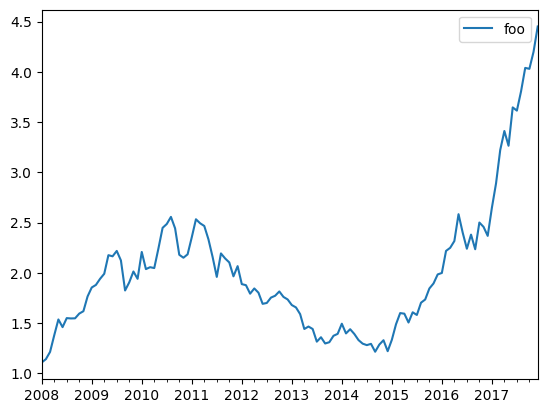

In [ ]:
from bt.algos import Algo, Rebalance, RunMonthly
from pandas.tseries.offsets import MonthBegin

df = pd.DataFrame(
    np.cumprod(1 + returns),
    index=pd.date_range(start="2008-01-01", periods=12 * 10, freq=MonthBegin()),
    columns=["foo"],
)
df.plot()

In [ ]:
pd.Timestamp("2008-01-02") + pd.DateOffset(month=3)

Timestamp('2008-03-02 00:00:00')

In [ ]:
from bt.core import Strategy
from bt.algos import StatTotalReturn


class Signal(Algo):
    """
    신호를 생성하는 클래스
    """
    def __init__(self, lookback=pd.DateOffset(month=3), lag=pd.DateOffset(days=0)):
        super().__init__()
        self.lookback = lookback
        self.lag = lag

    def __call__(self, target: Strategy):
        selected = "foo"
        t0 = target.now - self.lag # 기준일

        if target.universe[selected].index[0] > t0: # 기준일 보다 미래인경우..
            return False

        prc = target.universe[selected].loc[t0 - self.lookback : t0] # 기간 동안의 가격 ( 3개월 )
        trend = prc.iloc[-1] / prc.iloc[0] - 1 # 기간 가격 변화율
        signal = trend > 0.0 # 가격이 상승했는지, 하락했는지

        if signal: # 상승
            target.temp["Signal"] = 1.0 # Signal 은 temp의 Custom key이다. 다른 문자열로 바꿔도 됨.
        else: # 하락
            target.temp["Signal"] = 0.0
        return True

In [ ]:
class WeighFromSignal(Algo):
    """
    신호를 기반으로 가중치를 설정하는 클래스
    """
    def __init__(self):
        super().__init__()

    def __call__(self, target:Strategy):
        selected = "foo"
        if target.temp["Signal"] is None:
            raise Exception("No Signal!")
        
        # temp의 weights는 예약key로 가중치를 뜻한다.
        target.temp["weights"] = {selected: target.temp["Signal"]}
        return True

In [ ]:
from bt.backtest import Backtest, Result

strategy = Strategy(
    "example1",
    [
        RunMonthly(),
        Signal(pd.DateOffset(months=12), pd.DateOffset(months=1)),
        WeighFromSignal(),
        Rebalance()
    ]
)
backtest = Backtest(strategy, df, integer_positions=False, progress_bar=True)
result:Result = bt.run(backtest)

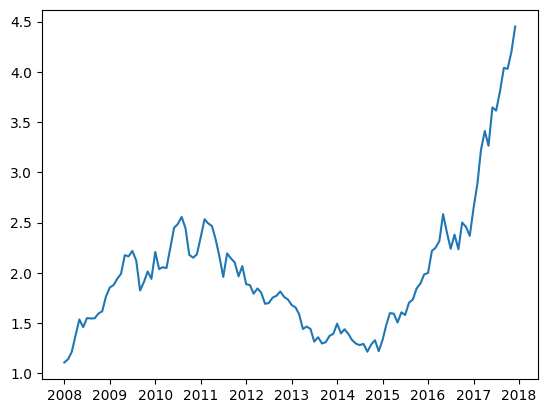

In [ ]:
sw = result.get_security_weights().iloc[1:]
plt.plot(df.index, df)
plt.plot(sw.index, sw)
plt.show()

In [ ]:
backtest.positions.plot()

TypeError: no numeric data to plot

<Axes: >

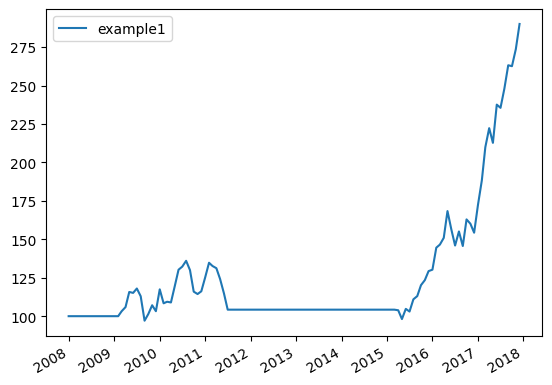

In [ ]:
result.prices.plot()

In [ ]:
result.stats

,example1
start,2007-12-31 00:00:00
end,2017-12-01 00:00:00
rf,0.0
total_return,1.900512
cagr,0.11333
max_drawdown,-0.27855
calmar,0.406858
mtd,0.05991
three_month,0.102033
six_month,0.22079
